# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

from sklearn.metrics import confusion_matrix

from scipy import signal

In [2]:
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


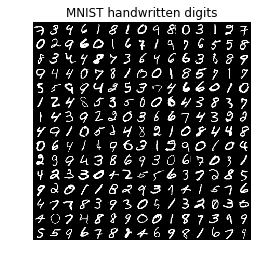

In [3]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )
## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

In [4]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

batch_size = 100
max_epochs = 10

## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [5]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


Using TensorFlow backend.


In [6]:
tf.reset_default_graph()

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')

    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [7]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [9]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [10]:
#Training Loop
valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            
            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))

    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 1 : Train Loss  0.200, Train acc  0.960,  Valid loss  0.132,  Valid acc  0.965
Epoch 2 : Train Loss  0.062, Train acc  0.990,  Valid loss  0.088,  Valid acc  0.976
Epoch 3 : Train Loss  0.020, Train acc  0.990,  Valid loss  0.074,  Valid acc  0.978
Epoch 4 : Train Loss  0.028, Train acc  0.990,  Valid loss  0.063,  Valid acc  0.983
Epoch 5 : Train Loss  0.048, Train acc  0.990,  Valid loss  0.059,  Valid acc  0.984
Epoch 6 : Train Loss  0.056, Train acc  0.970,  Valid loss  0.058,  Valid acc  0.985
Epoch 7 : Train Loss  0.036, Train acc  0.980,  Valid loss  0.053,  Valid acc  0.986
Epoch 8 : Train Loss  0.025, Train acc  0.990,  Valid loss  0.056,  Valid acc  0.985
Epoch 9 : Train Loss  0.041, Train acc  0.980,  Valid loss  0.052,  Valid acc  0.986
Epoch 10 : Train Loss  0.029, Train acc  0.990,  Valid loss  0.051,  Valid acc  0.985
Test Loss  0.045, Test acc  0.986


(<matplotlib.text.Text at 0x21b8f84f7b8>,
 (0.75, 1.03))

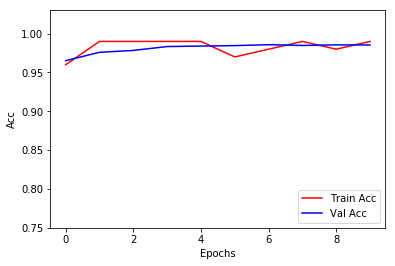

In [11]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

## Keras

In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.optimizers import Adam

from keras import backend as K
model = None

In [13]:
# This is needed to be able to work properly in Jupyter Notebooks with Keras
# We tell Keras to remove all the elements in the graph it had previously created
session = K.get_session()
if model is not None:
    model.reset_states() # Reset graph

model = Sequential()
# input: (28, 28, 1)
# applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, nchannels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# softmax activation, one-hot encoded target with categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [14]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [15]:
history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=32, epochs=10)

Epoch 1/10
55000/55000 [==============================] - 97s - loss: 0.1920 - acc: 0.9412    
Epoch 2/10
55000/55000 [==============================] - 100s - loss: 0.0691 - acc: 0.9793   
Epoch 3/10
55000/55000 [==============================] - 101s - loss: 0.0525 - acc: 0.9843   
Epoch 4/10
55000/55000 [==============================] - 97s - loss: 0.0440 - acc: 0.9866    
Epoch 5/10
55000/55000 [==============================] - 98s - loss: 0.0388 - acc: 0.9887    
Epoch 6/10
55000/55000 [==============================] - 100s - loss: 0.0325 - acc: 0.9897   
Epoch 7/10
55000/55000 [==============================] - 99s - loss: 0.0317 - acc: 0.9905    
Epoch 8/10
55000/55000 [==============================] - 100s - loss: 0.0300 - acc: 0.9909   
Epoch 9/10
55000/55000 [==============================] - 100s - loss: 0.0277 - acc: 0.9915   
Epoch 10/10
55000/55000 [==============================] - 99s - loss: 0.0254 - acc: 0.9920    


In [16]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels)

 9984/10000 [============================>.] - ETA: 0s

In [17]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.0220414140581
Test accuracy: 0.9935


In [18]:
for i in range(0, 1000):
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    if np.argmax(mnist_data.test.labels[i]) != np.argmax(res):
        print(i)

454
636
646
696
894


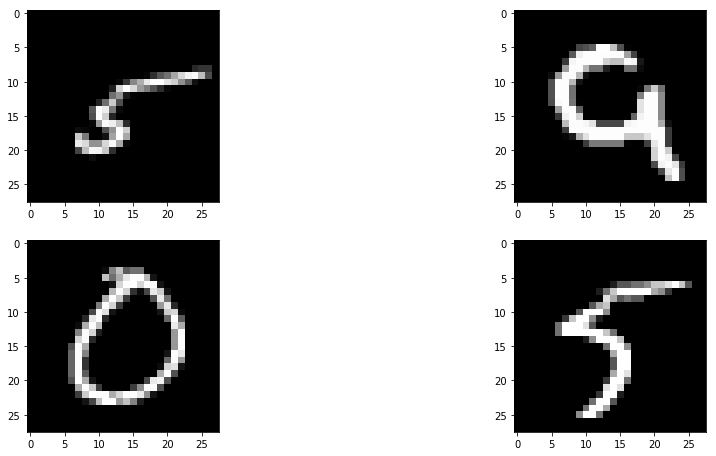

In [19]:
fig = plt.figure(figsize=(16,12))
image = mnist_data.test.images[450]
fig.add_subplot(321)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[582]
fig.add_subplot(322)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[740]
fig.add_subplot(323)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[947]
fig.add_subplot(324)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

In [20]:
for i in [450, 582, 740, 947]:
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    print("Network output = {}. True output {}".format(np.argmax(res), np.argmax(mnist_data.test.labels[i])))

Network output = 5. True output 5
Network output = 9. True output 9
Network output = 0. True output 0
Network output = 5. True output 5


In [21]:
prediction = model.predict(np.reshape(mnist_data.test.images[740], (1, 28, 28, 1)))
print(prediction)

[[  1.00000000e+00   6.65860913e-18   1.90776472e-13   4.52000397e-18
    1.60376032e-15   6.48257439e-15   6.60583784e-13   3.63093336e-15
    1.41297229e-15   9.70803624e-13]]


# Assignments

## <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>





We just place the kernel matrix on top of the pixels and multiply, just as shown in the first notebook.

\begin{align}
    y_{0,0} &= 1 \cdot 2 +2 \cdot 3 = 8 \\
    y_{1,0} &= 2 \cdot 1 + 2 \cdot 1 + 2 \cdot 2 + 2 \cdot 3 = 14 \\
    y_{0,1} &= 2 \cdot 2 + 2 \cdot 2 + 3 \cdot 3 + 1 \cdot 1 + 2 \cdot 2 = 20 \\
    y_{1,1} &= 2 \cdot 2 + 2 \cdot 1 + 2 \cdot 2 + 3 \cdot 2 + 3 \cdot 3 = 25
\end{align}

We can verify the result with scipy

In [22]:
x = np.array([[0, 0, 0, 1],[0, 0,1,2],[0,0,2,3],[0,1,2,3]])
k=np.array([[0,0,2],[0,1,2],[0,2,3]])
k = np.rot90(k, 2)
y = signal.convolve2d(x, k, 'valid')

print(y)

[[ 8 20]
 [14 25]]



## <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


I need to import this again, otherwise the training will fail.

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [24]:
tf.reset_default_graph()

filters_1 = 10
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2, filters_2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())

with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())

    x = flatten(x)
    print('Flatten \t', x.get_shape()) 

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')

    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 10)
pool1 		 (?, 14, 14, 10)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  1684 trainable parameters.


In [25]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [26]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 0 : Train Loss  2.339, Train acc  0.090,  Valid loss  2.337,  Valid acc  0.122
Epoch 1 : Train Loss  0.657, Train acc  0.820,  Valid loss  0.566,  Valid acc  0.826
Epoch 2 : Train Loss  0.366, Train acc  0.890,  Valid loss  0.377,  Valid acc  0.886
Epoch 3 : Train Loss  0.459, Train acc  0.890,  Valid loss  0.318,  Valid acc  0.902
Epoch 4 : Train Loss  0.157, Train acc  0.960,  Valid loss  0.260,  Valid acc  0.918
Epoch 5 : Train Loss  0.275, Train acc  0.930,  Valid loss  0.233,  Valid acc  0.931
Epoch 6 : Train Loss  0.183, Train acc  0.940,  Valid loss  0.216,  Valid acc  0.933
Epoch 7 : Train Loss  0.195, Train acc  0.950,  Valid loss  0.204,  Valid acc  0.937
Epoch 8 : Train Loss  0.284, Train acc  0.910,  Valid loss  0.203,  Valid acc  0.937
Epoch 9 : Train Loss  0.159, Train acc  0.960,  Valid loss  0.183,  Valid acc  0.946
Epoch 10 : Train Loss  0.128, Train acc  0.970,  Valid loss  0.175,  Valid acc  0.947
Test Loss  0.178, Test acc  0.945


(<matplotlib.text.Text at 0x21b91e71198>,
 (0.75, 1.03))

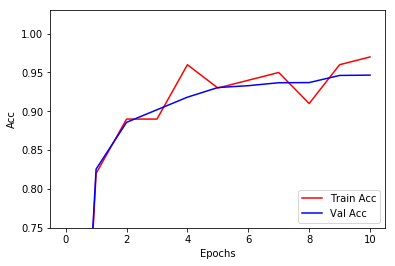

In [27]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

In [28]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 

INFO:tensorflow:Restoring parameters from ./mnist_cnn


In [29]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.94510001]


## <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [31]:
tf.reset_default_graph()

filters_1 = 10
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2, filters_2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    x = flatten(x)
    print('Flatten \t', x.get_shape()) 
    
with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 10)
pool1 		 (?, 14, 14, 10)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  1684 trainable parameters.


In [32]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [33]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 0 : Train Loss  2.321, Train acc  0.120,  Valid loss  2.327,  Valid acc  0.089
Epoch 1 : Train Loss  0.457, Train acc  0.860,  Valid loss  0.561,  Valid acc  0.822
Epoch 2 : Train Loss  0.514, Train acc  0.850,  Valid loss  0.391,  Valid acc  0.882
Epoch 3 : Train Loss  0.441, Train acc  0.890,  Valid loss  0.326,  Valid acc  0.902
Epoch 4 : Train Loss  0.292, Train acc  0.880,  Valid loss  0.283,  Valid acc  0.914
Epoch 5 : Train Loss  0.457, Train acc  0.830,  Valid loss  0.265,  Valid acc  0.918
Epoch 6 : Train Loss  0.388, Train acc  0.890,  Valid loss  0.251,  Valid acc  0.924
Epoch 7 : Train Loss  0.220, Train acc  0.920,  Valid loss  0.222,  Valid acc  0.933
Epoch 8 : Train Loss  0.280, Train acc  0.910,  Valid loss  0.207,  Valid acc  0.939
Epoch 9 : Train Loss  0.290, Train acc  0.890,  Valid loss  0.202,  Valid acc  0.941
Epoch 10 : Train Loss  0.367, Train acc  0.910,  Valid loss  0.191,  Valid acc  0.944
Test Loss  0.207, Test acc  0.937


(<matplotlib.text.Text at 0x21b9230ba58>,
 (0.75, 1.03))

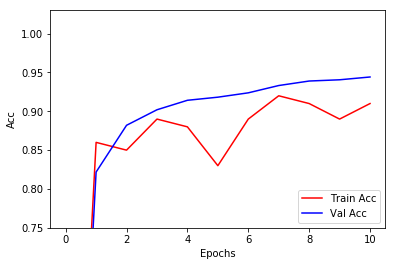

In [34]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

In [35]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [36]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 0.

INFO:tensorflow:Restoring parameters from ./mnist_cnn


In [37]:
print(confusion_matrix(mnist_data.test.labels.argmax(1), y_pred_1.argmax(1))) 

[[ 938    3    7    0    3    2   15    6    4    2]
 [   1 1107    2    2    3    1    6    5    7    1]
 [   7    3  940   26    4   16    5   13   16    2]
 [   4    3   27  941    0   14    0    7   11    3]
 [   3    4    7    0  944    0    4    4    5   11]
 [   8    2   12   12    1  818    5    2   29    3]
 [  15    4    2    0    2    6  918    0   10    1]
 [   2    3   18    7    8    1    1  978    0   10]
 [  22    1    8    2    8   13   12    0  893   15]
 [  15    4   11    7   25    4    5    7   28  903]]


In [38]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.93800002]


## <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>


In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=True, # Flatten the images to vectors
                                      )

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [8]:
model = None

session = K.get_session()
if model is not None:
    model.reset_states() # Reset graph

In [9]:
n_hidden1 = 2

model = Sequential()

model.add(Dense(n_hidden1, activation='elu', input_dim=num_features))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print('Parameters {}'.format(model.count_params()))

Parameters 1600


In [10]:
epochs = 10
batch_size = 100

#history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=100, epochs=10)

for e in range(epochs):
    train_loss = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=batch_size, nb_epoch=1, verbose = 0)
    val_score, val_acc = model.evaluate(mnist_data.validation.images, mnist_data.validation.labels, batch_size=batch_size, verbose = 0)
    
    print(val_acc)

C:\Developer\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.415799997449
0.500799993873
0.552399997711
0.595999997854
0.615999999046
0.632800002098
0.654199999571
0.660400000811
0.670200002193
0.674800001383


In [11]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels)

 7840/10000 [======================>.......] - ETA: 0s

In [12]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.02864399242
Test accuracy: 0.67


 Or just train immediately